# Keypoint Heatmap Encoder

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
voc_root = os.path.join(project_root, "data", "VOC2012")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from data.voc_dataset import VOCDataset
from centernet.encoder import KeypointHeatmapEncoder

In [24]:
dataset = VOCDataset('trainval', root=voc_root)
encoder = KeypointHeatmapEncoder(heatmap_shape=(37,37), std=0.1)

gt_boxes has shape torch.Size([2, 4])
gt_labels has shape torch.Size([2])
Max value from heatmap 1.0


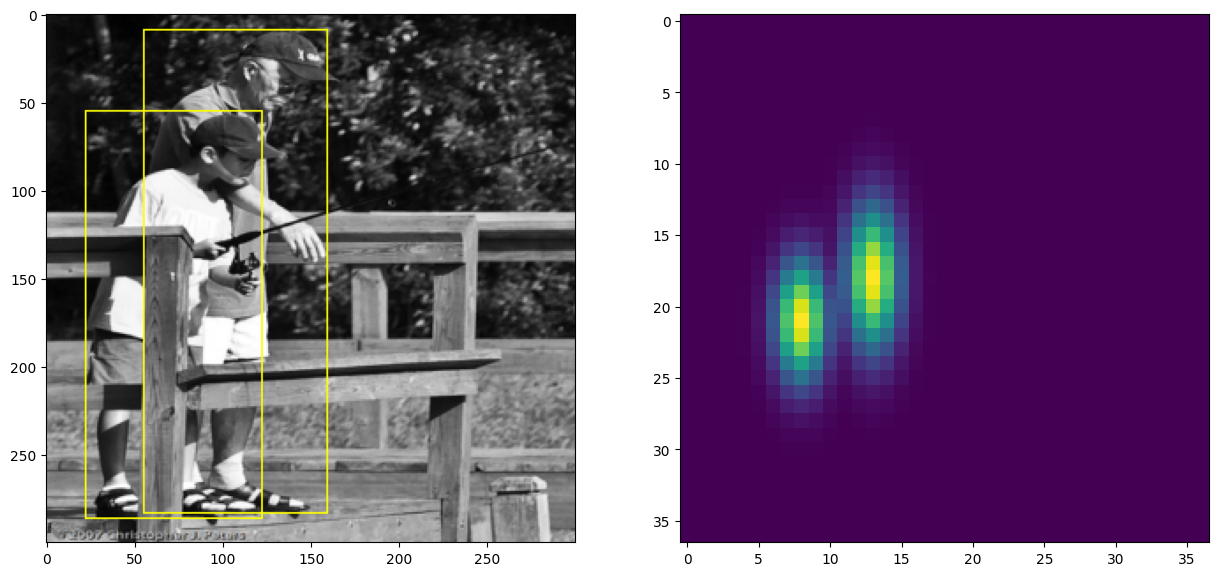

In [25]:
img_tensor, bboxes = dataset[1000]
img_tensor = img_tensor.permute(1, 2, 0).contiguous()

img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

gt_boxes = bboxes[:, :4]
gt_labels = bboxes[:, 4]
print("gt_boxes has shape", gt_boxes.shape)
print("gt_labels has shape", gt_labels.shape)

for i, box in enumerate(gt_boxes):
    xmin, ymin, xmax, ymax = box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=1)
    
    
center_mask, center_cls_heatmap, center_reg_heatmap = encoder.encode(gt_boxes, gt_labels.int())
heatmap = center_cls_heatmap.sum(dim=0).numpy()
print("Max value from heatmap", heatmap.max())


fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(img)
axs[1].imshow(heatmap)